In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/horse-or-human/horse-or-human/train/humans/human03-07.png
/kaggle/input/horse-or-human/horse-or-human/train/humans/human10-18.png
/kaggle/input/horse-or-human/horse-or-human/train/humans/human10-20.png
/kaggle/input/horse-or-human/horse-or-human/train/humans/human11-02.png
/kaggle/input/horse-or-human/horse-or-human/train/humans/human07-09.png
/kaggle/input/horse-or-human/horse-or-human/train/humans/human09-23.png
/kaggle/input/horse-or-human/horse-or-human/train/humans/human03-24.png
/kaggle/input/horse-or-human/horse-or-human/train/humans/human12-11.png
/kaggle/input/horse-or-human/horse-or-human/train/humans/human13-23.png
/kaggle/input/horse-or-human/horse-or-human/train/humans/human11-05.png
/kaggle/input/horse-or-human/horse-or-human/train/humans/human13-04.png
/kaggle/input/horse-or-human/horse-or-human/train/humans/human01-25.png
/kaggle/input/horse-or-human/horse-or-human/train/humans/human06-17.png
/kaggle/input/horse-or-human/horse-or-human/train/humans/human14

In [2]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:

data_dir = '/kaggle/input/horse-or-human/horse-or-human/'
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
data_path = 'train'
train_dataset = torchvision.datasets.ImageFolder(
        root=data_dir+data_path,
        transform=transform
    )
data_path = 'validation'
test_dataset = torchvision.datasets.ImageFolder(
        root=data_dir+ data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=True
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=True
    )

(32, 3, 300, 300)
(32, 300, 300)


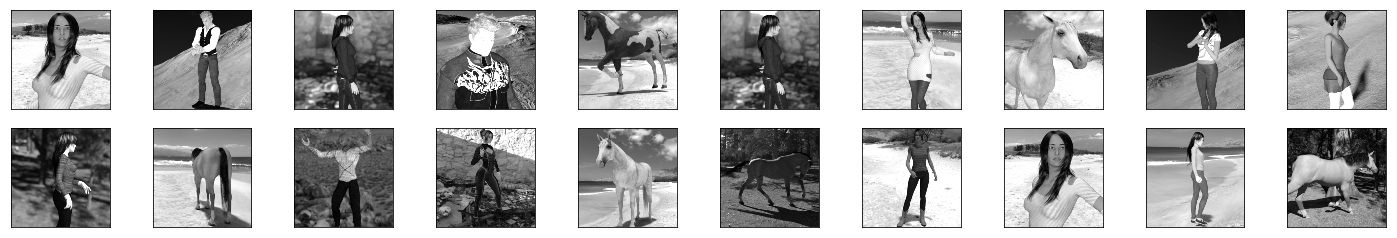

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
print(images.shape)
images = images[:,0,:,:]
print(images.shape)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), 'gray')

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        # convolutional layer (sees 147x147x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3)
        # convolutional layer (sees 71x71x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3)
        # convolutional layer (sees 33x33x64 tensor)
        self.conv4 = nn.Conv2d(64, 64, 3)
        # convolutional layer (sees 14x14x64 tensor)
        self.conv5 = nn.Conv2d(64, 64, 3)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 7 * 7 -> 500)
        self.fc1 = nn.Linear(3136, 512)
        # linear layer (512 -> 1)
        self.fc2 = nn.Linear(512, 1)
#         dropout_layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))

        # flatten image input
        x = x.view(-1, 64 * 7 * 7)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer
        x = self.fc2(x)
        return x
## complete this function



# move tensors to GPU if CUDA is available


In [7]:
from torch.nn import init
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    
    classname = m.__class__.__name__
    # for every Linear layer in a model
    # m.weight.data shoud be taken from a normal distribution
    # m.bias.data should be 0
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
      init.normal_(m.weight.data, 0.0, 0.02)    
    if hasattr(m, 'bias') and m.bias is not None:
      init.constant_(m.bias.data, 0.0)    


In [8]:
# create a complete CNN
model = Net()
model.apply(weights_init_normal)
print(model)
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [9]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.BCEWithLogitsLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
valid_loss_min = np.Inf
n_epochs = 25

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.unsqueeze(1)

        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        target = target.type(torch.FloatTensor)
        optimizer.zero_grad()
        output = model(data)
        
        output = output.type(torch.FloatTensor)

        loss  = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*32
        
    print("Epoch: {} \tTraining Loss: {:.6f}".format(
        epoch, train_loss/len(train_loader)))

Epoch: 1 	Training Loss: 22.190669
Epoch: 2 	Training Loss: 22.184254
Epoch: 3 	Training Loss: 22.178719
Epoch: 4 	Training Loss: 22.169800
Epoch: 5 	Training Loss: 22.163202
Epoch: 6 	Training Loss: 22.164976
Epoch: 7 	Training Loss: 22.150156
Epoch: 8 	Training Loss: 22.166110
Epoch: 9 	Training Loss: 22.182314
Epoch: 10 	Training Loss: 22.178958
Epoch: 11 	Training Loss: 22.180527
Epoch: 12 	Training Loss: 22.178546
Epoch: 13 	Training Loss: 22.176705
Epoch: 14 	Training Loss: 22.166332
Epoch: 15 	Training Loss: 22.166667
Epoch: 16 	Training Loss: 22.166818
Epoch: 17 	Training Loss: 22.151824
Epoch: 18 	Training Loss: 22.182984
Epoch: 19 	Training Loss: 22.152303
Epoch: 20 	Training Loss: 22.145418
Epoch: 21 	Training Loss: 22.164350
Epoch: 22 	Training Loss: 22.156747
Epoch: 23 	Training Loss: 22.185221
Epoch: 24 	Training Loss: 22.163695
Epoch: 25 	Training Loss: 22.169562


In [11]:
model.eval()
test_loss = 0.0
for batch_idx, (data, target) in enumerate(test_loader):
    target = target.unsqueeze(1)

    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    target = target.type(torch.FloatTensor).cuda()
    loss = criterion(output, target)
    # update average validation loss 
    test_loss += loss.item()*32

test_loss = test_loss/len(test_loader)
    
    
    
print("Test loss {:.6f}".format(test_loss/len(test_loader)))


Test loss 2.774440
